In [34]:
import pandas as pd
df=pd.read_csv(r"df_final_demo.txt")
part1=pd.read_csv(r"df_final_web_data_pt_1.txt")
part2=pd.read_csv(r"df_final_web_data_pt_2.txt")
df_concated=pd.concat([part1,part2], ignore_index=True)
Variation=pd.read_csv(r"df_final_experiment_clients.txt")
merged = pd.merge(df, df_concated, on='client_id', how='inner')
full_df = pd.merge(merged, Variation, on='client_id', how='inner')

In [35]:
full_df["clnt_age"]=full_df["clnt_age"].round(0)


In [36]:
full_df['gendr'] = full_df['gendr'].replace('X', 'U').fillna('U')


In [37]:
test_table=full_df[full_df['Variation'].str.lower() == 'test']


In [38]:
#droping duplicates
test_table=test_table.drop_duplicates()

In [39]:
#dropping the null value
test_table =test_table.dropna()

In [40]:
control_table = full_df[full_df['Variation'].str.lower() == 'control']

In [41]:
#droping duplicates
control_table=control_table.drop_duplicates()

In [42]:
#dropping the null value
control_table =control_table.dropna()

In [43]:
#completion status YES/NO---TEST

#completion status YES/NO
completed_clients = test_table[test_table["process_step"] == "confirm"]["client_id"].unique()

test_table['completed_flag'] = test_table['client_id'].isin(completed_clients).astype(int)
test_table['completed_flag'] = test_table['completed_flag'].map({1: 'yes', 0: 'no'})

In [44]:
#completion status YES/NO---CONTROL
#completion status YES/NO
completed_clients = control_table[control_table["process_step"] == "confirm"]["client_id"].unique()
control_table['completed_flag'] = control_table['client_id'].isin(completed_clients).astype(int)
control_table['completed_flag'] =control_table['completed_flag'] .map({1: 'yes', 0: 'no'})


In [45]:
#time spent on each step
test_table = test_table.copy()

# Step 2: Convert date_time in test_table, not merged
test_table['date_time'] = pd.to_datetime(test_table['date_time'], errors='coerce')

# Step 3: Sort and calculate time spent
sorted_test = test_table.sort_values(by=['visit_id', 'date_time'])

test_table['time_spent_minutes'] = (
    sorted_test.groupby('visit_id')['date_time']
    .diff()
    .abs()
    .dt.total_seconds() / 60
    
)



In [46]:
mean = test_table['time_spent_minutes'].mean()
test_table['time_spent_minutes'].fillna(mean, inplace=True)
test_table['time_spent_minutes']=test_table['time_spent_minutes'].round(2)

C:\Users\prodd\AppData\Local\Temp\ipykernel_19880\2205890008.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_table['time_spent_minutes'].fillna(mean, inplace=True)


In [47]:
Q1 = test_table['time_spent_minutes'].quantile(0.25)
Q3 = test_table['time_spent_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

test_table = test_table[(test_table['time_spent_minutes'] >= lower_bound) & (test_table['time_spent_minutes'] <= upper_bound)]

In [48]:
# Make a clean copy
control_table = control_table.copy()

# Step 2: Convert date_time in test_table, not merged
control_table['date_time'] = pd.to_datetime(control_table['date_time'], errors='coerce')

# Step 3: Sort and calculate time spent
sorted_control = control_table.sort_values(by=['visit_id', 'date_time','client_id'])

control_table['time_spent_minutes'] = (
    sorted_control.groupby('visit_id')['date_time']
    .diff()
    .abs()
    .dt.total_seconds() / 60
)

In [49]:
mean = control_table['time_spent_minutes'].mean()
control_table['time_spent_minutes'].fillna(mean, inplace=True)
control_table['time_spent_minutes']=control_table['time_spent_minutes'].round(2)

C:\Users\prodd\AppData\Local\Temp\ipykernel_19880\4207991998.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  control_table['time_spent_minutes'].fillna(mean, inplace=True)


In [50]:
Q1 = control_table['time_spent_minutes'].quantile(0.25)
Q3 = control_table['time_spent_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
control_table= control_table[(control_table['time_spent_minutes'] >= lower_bound) & (control_table['time_spent_minutes'] <= upper_bound)]

In [51]:
step_order = {
    'start': 1,
    'step_1': 2,
    'step_2': 3,
    'step_3': 4,
    'confirm': 5
}


In [52]:
def individual_error_rate(df, step_order):
    df = df.replace({'process_step': step_order})
    df = df.sort_values(['client_id', 'visit_id', 'date_time'])
    df['prev_step'] = df.groupby(['client_id', 'visit_id'])['process_step'].shift()
    df['backward_move'] = df['process_step'] < df['prev_step']
    return df.groupby('client_id')['backward_move'].mean().reset_index(name='error_rate')

test_individual = individual_error_rate(test_table, step_order)
control_individual = individual_error_rate(control_table, step_order)

C:\Users\prodd\AppData\Local\Temp\ipykernel_19880\3720362767.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'process_step': step_order})
C:\Users\prodd\AppData\Local\Temp\ipykernel_19880\3720362767.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'process_step': step_order})


In [ ]:
test_individual['error_rate']=test_individual['error_rate'].apply(lambda x: f"{round(x * 100, 2)}%")

In [ ]:
control_individual['error_rate']=control_individual['error_rate'].apply(lambda x: f"{round(x * 100, 2)}%")

In [55]:
test_table=pd.merge(test_table, test_individual, on='client_id', how='inner')

In [64]:
control_individual["error_rate"].mean()

np.float64(0.04092501840612674)

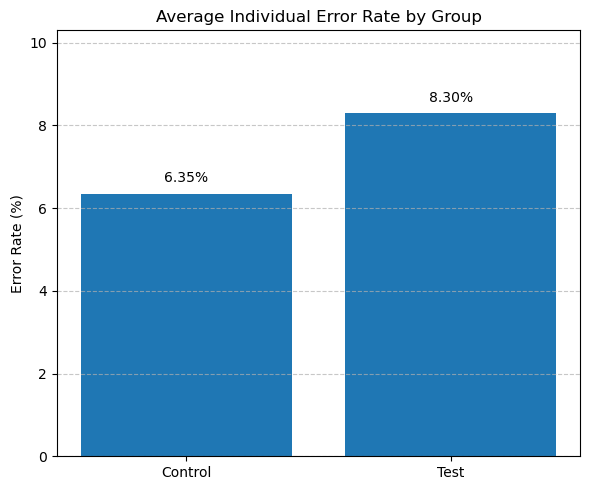

In [65]:
import matplotlib.pyplot as plt

# Error rates in percentage
error_test = 8.30
error_control = 6.35
groups = ['Control', 'Test']
errors = [error_control, error_test]

# Plotting
plt.figure(figsize=(6, 5))
bars = plt.bar(groups, errors)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.2f}%', ha='center', va='bottom')

plt.title('Average Individual Error Rate by Group')
plt.ylabel('Error Rate (%)')
plt.ylim(0, max(errors) + 2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
control_table=pd.merge(control_table, control_individual, on='client_id', how='inner')

In [ ]:
final_clean=pd.concat([test_table,control_table],ignore_index=True)

In [ ]:
final_clean.columns = final_clean.columns.str.replace(' ', '_').str.lower()

In [ ]:
final_clean

In [ ]:
final_clean.to_csv("final_clean.csv", index=False)